In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
from PIL import Image
import numpy as np

data = []
labels = []

for tumor_type in ['yes', 'no']:
    directory = f"/content/drive/MyDrive/archive/brain_tumor_dataset/{tumor_type}"
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist.")
        continue

    for r, d, f in os.walk(directory):
        for file in f:
            if '.jpg' in file:
                try:
                    # image path
                    path = os.path.join(r, file)

                    # read the image and resize
                    img = Image.open(path)
                    img = img.resize((128,128))
                    img = np.array(img)

                    # if the size of the image is correct
                    if img.shape == (128,128,3):
                        data.append(img)

                        label = 0 if tumor_type == 'yes' else 1
                        labels.append(label)
                except Exception as e:
                    print(f"Error processing file {file}: {e}")


In [ ]:
data = np.array(data)
print(data.shape)

(139, 128, 128, 3)


In [ ]:
labels = np.array(labels)
print(labels.shape)

(139,)


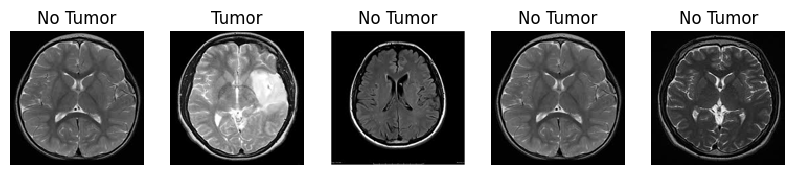

In [ ]:
num_samples_to_display = 5
random_indices = np.random.choice(len(data), num_samples_to_display, replace=False)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(data[idx], interpolation='nearest')
    plt.title('Tumor' if labels[idx] == 0 else 'No Tumor')
    plt.axis('off')
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size= 0.3, random_state= 42)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(97, 128, 128, 3)
(42, 128, 128, 3)


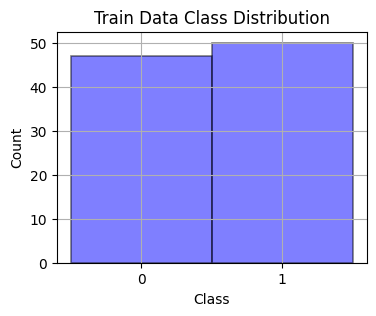

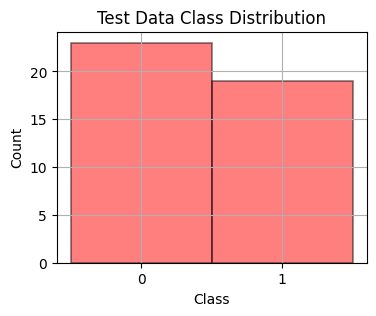

In [ ]:
#Train
plt.figure(figsize=(4, 3))
plt.hist(y_train, bins=np.arange(3)-0.5, alpha=0.5, color='blue', edgecolor='black', linewidth=1.2)
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train Data Class Distribution')
plt.grid(True)
plt.show()

#Test
plt.figure(figsize=(4, 3))
plt.hist(y_test, bins=np.arange(3)-0.5, alpha=0.5, color='red', edgecolor='black', linewidth=1.2)
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Test Data Class Distribution')
plt.grid(True)
plt.show()

In [ ]:
def preProcess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255

    return img

In [ ]:
x_train = np.array(list(map(preProcess, x_train)))
x_test = np.array(list(map(preProcess, x_test)))

In [ ]:
x_train = x_train.reshape(-1, 128, 128,1)
x_test = x_test.reshape(-1, 128, 128,1)

In [ ]:
dataGen = ImageDataGenerator(width_shift_range= 0.1,
                             height_shift_range= 0.1,
                             zoom_range= 0.1,
                             rotation_range= 10)

In [ ]:
dataGen.fit(x_train)

In [ ]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [ ]:
model = Sequential()
model.add(Conv2D(32,input_shape = (128,128,1), kernel_size = (5,5), activation="relu", padding = "same"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units= 2, activation="softmax"))

model.compile(loss = "categorical_crossentropy", optimizer = ("Adam"), metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(x_train, y_train, epochs=30, batch_size=40, verbose=1,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/30
3/3 [==============================] - 7s 1s/step - loss: 0.7835 - accuracy: 0.5155 - val_loss: 0.7161 - val_accuracy: 0.4524
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 0.6937 - accuracy: 0.5155 - val_loss: 0.6910 - val_accuracy: 0.4524
Epoch 3/30
3/3 [==============================] - 3s 1s/step - loss: 0.6830 - accuracy: 0.5155 - val_loss: 0.6781 - val_accuracy: 0.6190
Epoch 4/30
3/3 [==============================] - 4s 2s/step - loss: 0.6663 - accuracy: 0.6598 - val_loss: 0.6507 - val_accuracy: 0.6190
Epoch 5/30
3/3 [==============================] - 4s 949ms/step - loss: 0.6177 - accuracy: 0.7010 - val_loss: 0.7059 - val_accuracy: 0.5000
Epoch 6/30
3/3 [==============================] - 3s 1s/step - loss: 0.6102 - accuracy: 0.6804 - val_loss: 0.6798 - val_accuracy: 0.5952
Epoch 7/30
3/3 [==============================] - 3s 929ms/step - loss: 0.6106 - accuracy: 0.6701 - val_loss: 0.5804 - val_accuracy: 0.7381
Epoch 8/30
3/3 [===================

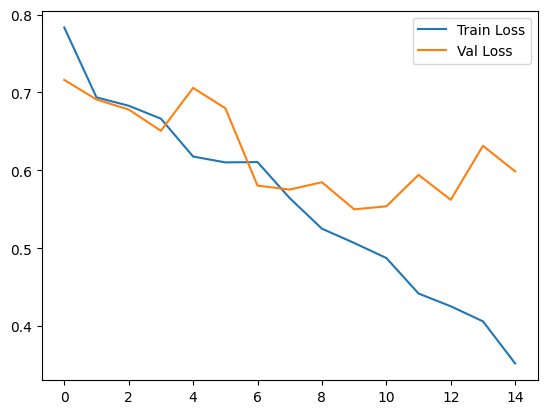

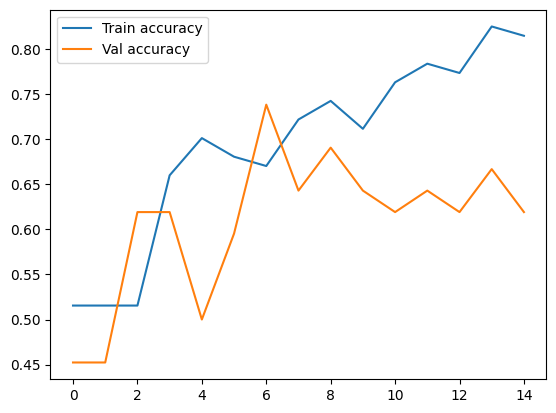

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label = "Train accuracy")
plt.plot(history.history["val_accuracy"], label = "Val accuracy")
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(x_test,y_test, verbose = 1)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

2/2 [==============================] - 1s 106ms/step - loss: 0.5499 - accuracy: 0.6429
Test loss:  0.5498860478401184
Test accuracy:  0.6428571343421936


2/2 [==============================] - 1s 130ms/step


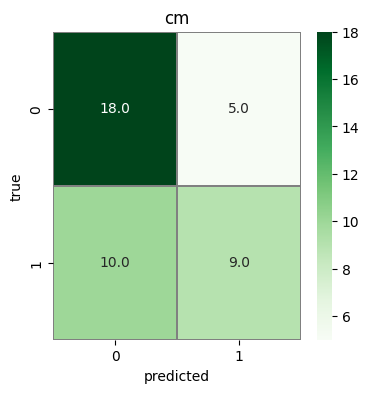

In [ ]:
y_pred = model.predict(x_test)

y_pred_class = np.argmax(y_pred, axis = 1)

Y_true = np.argmax(y_test, axis= 1)

cm = confusion_matrix(Y_true, y_pred_class)

f, ax = plt.subplots(figsize = (4,4))
sns.heatmap(cm, annot= True, linewidths= 0.01, cmap = "Greens", linecolor="gray", fmt= ".1f", ax = ax)
plt.xlabel("predicted")
plt.ylabel("true")
plt.title("cm")
plt.show()
